# NBS <a id='network-based-statistic'></a>


    '''
    Performs the NBS for populations X and Y for a t-statistic threshold of
    alpha.
    Parameters
    ----------
    x : NxNxP np.ndarray
        matrix representing the first population with P subjects. must be
        symmetric.
    y : NxNxQ np.ndarray
        matrix representing the second population with Q subjects. Q need not
        equal P. must be symmetric.
    thresh : float
        minimum t-value used as threshold
    k : int
        number of permutations used to estimate the empirical null 
        distribution
    tail : {'left', 'right', 'both'}
        enables specification of particular alternative hypothesis
        'left' : mean population of X < mean population of Y
        'right' : mean population of Y < mean population of X
        'both' : means are unequal (default)
    paired : bool
        use paired sample t-test instead of population t-test. requires both
        subject populations to have equal N. default value = False
    verbose : bool
        print some extra information each iteration. defaults value = False
    seed : hashable, optional
        If None (default), use the np.random's global random state to generate random numbers.
        Otherwise, use a new np.random.RandomState instance seeded with the given value.

In [2]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib  # load the beta maps in python
from nilearn import plotting  # plot nifti images
from bct import nbs
from scipy.io import savemat
from mne.viz import plot_connectivity_circle

/usr/local/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [59]:
data_dir = '/Volumes/psybrain/ADM/derivatives'
results_dir = '/Volumes/schnyer/Megan/adm_mem-fc/analysis/withhc/stats/'
nibs_dir='/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/with_hc'

tasks = ['MemMatch1', 'MemMatch2', 'MemMatch3']
trial_types = ['cue', 'match', 'mismatch']

atlas_file='/Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz'
atlas_lut='/Volumes/psybrain/ADM/derivatives/nibs/power264_labels.tsv'

In [60]:
atlas = pd.read_csv(atlas_lut, sep='\t').set_index('index')
atlas = atlas.append({'regions': 'HC Sherman'}, ignore_index=True)
atlas.regions.unique()

array(['Uncertain', 'Sensory/somatomotor Hand',
       'Sensory/somatomotor Mouth', 'Cingulo-opercular Task Control',
       'Auditory', 'Default mode', 'Memory retrieval?',
       'Ventral attention', 'Visual', 'Fronto-parietal Task Control',
       'Salience', 'Subcortical', 'Cerebellar', 'Dorsal attention',
       'HC Sherman'], dtype=object)

In [61]:
atlas=atlas.drop([3,9,183], axis=0)
atlas = atlas.reset_index(drop=True)

In [62]:
hc = atlas.loc[atlas['regions'].str.contains('HC')].index.tolist()
dmn = atlas.loc[atlas['regions'].str.contains('Default')].index.tolist()
mem = atlas.loc[atlas['regions'].str.contains('Memory')].index.tolist()
fpn = atlas.loc[atlas['regions'].str.contains('Fronto-parietal')].index.tolist()

dmn_hc = np.concatenate((dmn, hc))
fpn_hc = np.concatenate((fpn, hc))
mem_hc = np.concatenate((mem, hc))

dmn_fpn = np.concatenate((dmn, fpn, hc))
dmn_mem = np.concatenate((dmn, mem, hc))
fpn_mem = np.concatenate((fpn, mem, hc))
dmn_fpn_mem = np.concatenate((dmn, fpn, mem, hc))

In [63]:
x = np.load('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/memmatch_fc_withhc_clean.npy', allow_pickle=True).flat[0]
fc_subs = np.loadtxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/fcsubs.txt', dtype=str)

In [64]:
adj = np.loadtxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/adj_dmn-hc_yagtoa_k5000_p044_t31.txt')
coords = np.loadtxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/coords_dmn_hc.txt', dtype=int)
print(adj.shape)
nbs_mat = np.repeat(adj[:, :, np.newaxis], x['cue'].shape[2], axis=2)*x['cue'][dmn_hc][:,dmn_hc,:]
np.nonzero(nbs_mat[:,:,0])
edges_fc = nbs_mat[np.nonzero(np.triu(nbs_mat[:,:,0]))]
edges_fc.shape

(59, 59)


(8, 89)

In [65]:
adj.shape

(59, 59)

(<Figure size 1080x1080 with 2 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x12de4f990>)

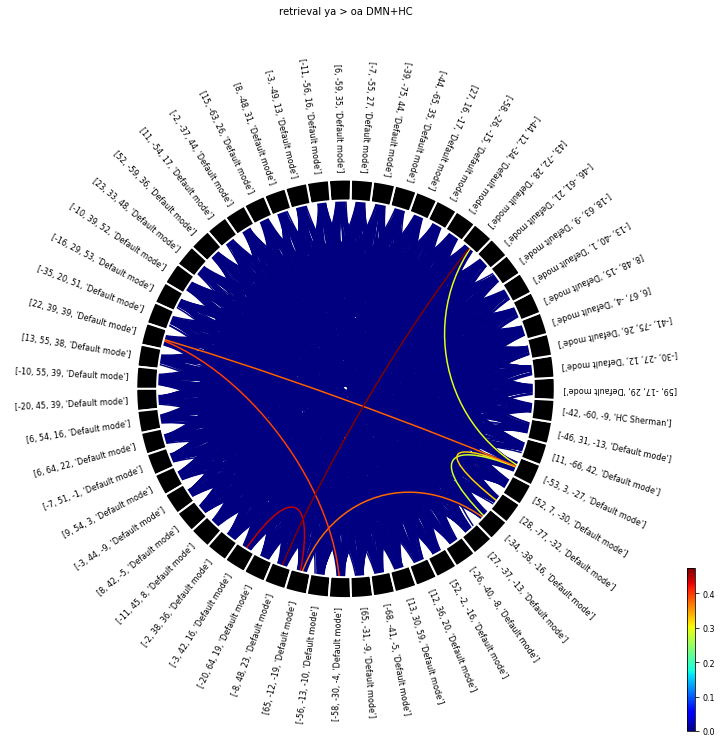

In [66]:
fig = plt.figure(figsize=(15, 15))
n_lines = int(np.sum((nbs_mat > 0) / 2))
node_labels = pd.DataFrame(np.hstack((coords, atlas.loc[dmn_hc].values))).values.tolist()


plot_connectivity_circle(nbs_mat.mean(axis=2), node_labels, n_lines=n_lines, fig=fig, title='retrieval ya > oa DMN+HC', 
                         fontsize_title=10, facecolor='white', textcolor='black', 
                         colormap='jet', colorbar=1, node_colors=['black'], 
                         node_edgecolor=['white'], show=False, interactive=False)

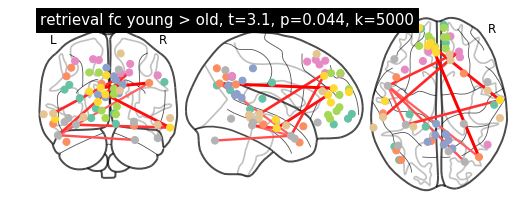

In [67]:
from nilearn import plotting

plotting.plot_connectome(nbs_mat.mean(axis=2), coords, edge_threshold=0, title='retrieval fc young > old, t=3.1, p=0.044, k=5000')

